In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from laspy.file import File
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

import sys

sys.path.insert(0,'..') # So we can import point_density_functions from parent directory
from point_density_functions import *
%load_ext autoreload
%matplotlib notebook

In [2]:
# Laefer
file_dir = '../../Data/parking_lot/'
filenames =list(pd.read_csv(file_dir+"filenames.txt",header=None)[0])
pt_files = list(pd.read_csv(file_dir+"pt_files.txt",header=None)[0])
# NYC
nyc_file_dir = '../../Data/NYC_topo/'
nyc_pt_file = ['las_points_NYC_flightid_975172.lz']
# USGS
usgs_file_dir = '../../Data/USGS/'
usgs_pt_files = ['las_points_flight_id_18TWK820985.lz']


# Corresponds to LAS 1.2 Point Data Record Format 1
columns_dublin_pt_cloud = [
    'X',
    'Y',
    'Z',
    'intensity',
    'return_number_byte',
    'classification_byte',
    'scan_angle',
    'user_data',
    'pt_src_id',
    'gps_time']

columns_point_cloud = [
    'X','Y','Z',
    'intensity',
    'flag_byte',
    'classification_flags',
    'classification_byte',
    'user_data',
    'scan_angle',
    'pt_src_id',
    'gps_time']

In [ ]:
# Extract points within a square around the desired point

# Parking Lot
# pt_x = 977037.343
# pt_y = 174586.034

# Corner of building
# pt_x_bldg = 977229.375
# pt_y_bldg = 174579.42

# Top of building
# pt_x = 977229.375
# pt_y = 174579.42

# Projects in back parking lot
# pt_x = 977458.238
# pt_y = 173302.388

# Solar panel
# pt_x = 977682.975
# pt_y = 174148.192

In [ ]:
# This works
# for filename in filenames:
#     create_df_hd5(file_dir,filename,columns_point_cloud)

## Flat surface
Identifying points in a parking lot to assess how consistently flat they are.  
Center point: 40.645789, -74.025951  
Easting - 977048.434  
Northing - 174555.792

### Point density - waterside parking lot

In [3]:
# Big parking lot rectangle
def rectangle(pt1,pt2,y_length,x_length):
    '''
    Function returns uv_inv and w, for use in selecting points within the rectangle
    Note: This function only works in 2D (horizontal plane)
    Inputs:
    pt1 - 2x1 numpy array with x and y coordinate for bottom point
    pt2 - 2xy numpy array with x and y coordinate for top point
    y_length - bottom-to-top length (positive is in direction of top from bottom point)
    x_length - left-to-right length (positive means pts are on left border, negative means they're on right)
    Outputs:
    uv_inv: 2xy numpy array - u and v are the sides of the rectangle.  uv = [u v] is a matrix with u and v as columns.
    w: 2x1 numpy array with (x,y) coordinates of reference (bottom) point.
    
    Reference: https://math.stackexchange.com/questions/190111/how-to-check-if-a-point-is-inside-a-rectangle
    '''
    unit_u = (pt2 - pt1)/np.linalg.norm(pt2-pt1)
    unit_v = np.array([unit_u[1],-1*unit_u[0]])
    u = unit_u*y_length
    v = unit_v*x_length
    uv = np.array([u,v]).T
    uv_inv = np.linalg.inv(uv)
    w = pt1
    return uv_inv,w,unit_u,unit_v

# rectangle_points_laefer = grab_points_big_rect(pt_files,file_dir,uv_inv,w)
# rectangle_points_nyc = grab_points_big_rect(nyc_pt_file,nyc_file_dir,uv_inv,w)
# rectangle_points_usgs = grab_points_big_rect(usgs_pt_files,usgs_file_dir,uv_inv,w)

In [ ]:
def print_out(SampleFlightList,pt_density_laefer_list,pt_density_nyc_list,pt_density_usgs_list,feet_from_point):
    # Laefer
    sd_laefer_total = np.mean([ss.flight_list_laefer[0].sd_dist for ss in SampleFlightList])
    sd_laefer_sample = np.mean([ss.flight_list_laefer[1].sd_dist for ss in SampleFlightList])
    avg_flight_paths_laefer = np.mean([len(flight.flight_list_laefer) for flight in SampleFlightList])-2

    phis_laefer_total = [ss.phi_laefer_total for ss in SampleFlightList]
    phis_laefer_sample = [ss.phi_laefer_sample for ss in SampleFlightList]

    print("2019 scan (Horizontal, {} samples): \n".format(len(SampleFlightList))+"*"*30)
    print("Avg points per square: {:2.2f} points".format((4 * feet_from_point**2)*np.mean(pt_density_laefer_list)))
    print("Avg density: {:2.4f} pts/sqft (SD: {:2.4f})".format(np.mean(pt_density_laefer_list),np.std(pt_density_laefer_list)))
    print("Avg number of flight paths per square: {:2.2f}".format(avg_flight_paths_laefer))
    print("\nphi_total: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_laefer_total),np.std(phis_laefer_total)))
    print("phi_sample: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_laefer_sample),np.std(phis_laefer_sample)))
    print("Total point dist from plane, SD: {:2.4f} feet".format(sd_laefer_total))
    print("Avg flight point dist from plane, SD: {:2.4f} feet".format(sd_laefer_total/np.mean(phis_laefer_total)))

    # NYC
    phis_nyc_total = [ss.phi_nyc_total for ss in SampleFlightList]
    phis_nyc_sample = [ss.phi_nyc_sample for ss in SampleFlightList]
    avg_flight_paths_nyc = np.mean([len(flight.flight_list_nyc) for flight in SampleFlightList])-2

    sd_nyc_total = np.mean([ss.flight_list_nyc[0].sd_dist for ss in SampleFlightList])
    sd_nyc_sample = np.mean([ss.flight_list_nyc[1].sd_dist for ss in SampleFlightList])

    print("\n2017 scan (Horizontal, {} samples): \n".format(len(SampleFlightList))+"*"*30)
    print("Avg points per square: {:2.2f} points".format((4 * feet_from_point**2)*np.mean(pt_density_nyc_list)))
    print("Avg density: {:2.4f} pts/sqft (SD: {:2.4f})".format(np.mean(pt_density_nyc_list),np.std(pt_density_nyc_list)))
    print("Avg number of flight paths per square: {:2.2f}".format(avg_flight_paths_nyc))
    print("\nphi_total: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_nyc_total),np.std(phis_nyc_total)))
    print("phi_sample: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_nyc_sample),np.std(phis_nyc_sample)))
    print("Total point dist from plane, SD: {:2.4f} feet".format(sd_nyc_total))
    print("Avg flight point dist from plane, SD: {:2.4f} feet".format(sd_nyc_total/np.mean(phis_nyc_total)))

    # USGS
    phis_usgs_total = [ss.phi_usgs_total for ss in SampleFlightList]
    phis_usgs_sample = [ss.phi_usgs_sample for ss in SampleFlightList]
    avg_flight_paths_usgs = np.mean([len(flight.flight_list_usgs) for flight in SampleFlightList])-2

    sd_usgs_total = np.mean([ss.flight_list_usgs[0].sd_dist for ss in SampleFlightList])
    sd_usgs_sample = np.mean([ss.flight_list_usgs[1].sd_dist for ss in SampleFlightList])

    print("\n2014 scan (Horizontal, {} samples): \n".format(len(SampleFlightList))+"*"*30)
    print("Avg points per square: {:2.2f} points".format((4 * feet_from_point**2)*np.mean(pt_density_usgs_list)))
    print("Avg density: {:2.4f} pts/sqft (SD: {:2.4f})".format(np.mean(pt_density_usgs_list),np.std(pt_density_usgs_list)))
    print("Avg number of flight paths per square: {:2.2f}".format(avg_flight_paths_usgs))
    print("\nphi_total: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_usgs_total),np.std(phis_usgs_total)))
    print("phi_sample: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_usgs_sample),np.std(phis_usgs_sample)))
    print("Total point dist from plane, SD: {:2.4f} feet".format(sd_usgs_total))
    print("Avg flight point dist from plane, SD: {:2.4f} feet".format(sd_usgs_total/np.mean(phis_usgs_total)))

In [ ]:
# Remove outliers and print the count: z < 0, z > 30
def remove_vertical_outliers(rectangle_points,z_low,z_high):
    outliers = rectangle_points[(rectangle_points['z_scaled']<z_low) | (rectangle_points['z_scaled']>z_high)].index
    rectangle_points = rectangle_points.drop(outliers)
    print("Number of outliers: {}".format(len(outliers)))
    return rectangle_points
rectangle_points_laefer = remove_vertical_outliers(rectangle_points_laefer,0,30)
rectangle_points_nyc = remove_vertical_outliers(rectangle_points_nyc,0,30)
rectangle_points_usgs = remove_vertical_outliers(rectangle_points_usgs,0,30)

## Sampling squares and Statistics

### Horizontal Density

In [ ]:
# Aggregators
pt_density_usgs_list, pt_density_nyc_list, pt_density_laefer_list = [],[],[]
avg_height_diff = []
sd_height_usgs, sd_height_nyc, sd_height_laefer = [],[],[]
SampleFlightList = []

In [ ]:
# Water front parking lot
pt1 = np.array([976534.92, 173979.05,0])
pt2 = np.array([976863.17, 174360.18,0])
u_length = np.linalg.norm(pt2-pt1)
v_length = 80
pt3 = np.array([976595.53720051, 173926.84315177,0]) # Backed into from previous 2D v calculation
uv_inv,w,unit_u,unit_v = rectangle(pt1[:2],pt2[:2],500,80)

rectangle_points_laefer = pd.read_pickle(file_dir+"rectangle_points_laefer.pkl")
rectangle_points_nyc = pd.read_pickle(file_dir+"rectangle_points_nyc.pkl")
rectangle_points_usgs = pd.read_pickle(usgs_file_dir+"rectangle_points_usgs.pkl")

In [ ]:
# Create center_points
feet_from_point = 3.281
center_points = center_point_sample(5000,pt1,pt2,pt3,u_length=u_length,v_length=v_length,border=[0.05,0.05])
mean_z = rectangle_points_laefer['z_scaled'].mean()
pts_thrown_out = 0

for center_point in center_points:
    square_points_usgs = in_horizontal_square(rectangle_points_usgs,center_point[:2],feet_from_point)
    square_points_nyc = in_horizontal_square(rectangle_points_nyc,center_point[:2],feet_from_point)
    square_points_laefer = in_horizontal_square(rectangle_points_laefer,center_point[:2],feet_from_point)
    
    laefer_flight_count = len(square_points_laefer['flight_id'].unique())
    nyc_flight_count = len(square_points_nyc['flight_id'].unique())
    usgs_flight_count = len(square_points_usgs['flight_id'].unique())
   
    laefer_density = square_points_laefer.shape[0] / laefer_flight_count
    nyc_density = square_points_nyc.shape[0]/nyc_flight_count
    usgs_density = square_points_usgs.shape[0] / usgs_flight_count
                        
#     print("Laefer: \n"+"*"*30)
#     print("Total points: {}".format(square_points_laefer.shape[0]))
#     print("Number of flights: {}".format(laefer_flight_count))
#     print("Points per flight: {}".format(laefer_density))
#     print("NYC: \n"+"*"*30)
#     print("Total points (NYC): {}".format(square_points_nyc.shape[0]))
#     print("Number of flights (NYC): {}".format(nyc_flight_count))
#     print("Points per flight: {}".format(nyc_density))    

    # If z_max > 10, <6 for any dataset, skip it
    if (square_points_nyc['z_scaled'].max()<mean_z+3) & \
       (square_points_usgs['z_scaled'].max()<mean_z+3) & \
       (square_points_laefer['z_scaled'].max()<mean_z+3):
        # Statistics!
                
        # Point density
        num_points_nyc = square_points_nyc.shape[0]
        pt_density_nyc_list.append(num_points_nyc / (4 * feet_from_point**2))        
        num_points_usgs = square_points_usgs.shape[0]
        pt_density_usgs_list.append(num_points_usgs / (4 * feet_from_point**2))        
        num_points_laefer = square_points_laefer.shape[0]
        pt_density_laefer_list.append(num_points_laefer / (4 * feet_from_point**2))        

        # Fit a plane
        norm_vector_nyc,_,square_points_nyc,_ = plane_fit(square_points_nyc)
        norm_vector_usgs,_,square_points_usgs,_ = plane_fit(square_points_usgs)
        norm_vector_laefer,_,square_points_laefer,_ = plane_fit(square_points_laefer)

        # Flight path specifics
        laefer_flight_list = create_flight_list(square_points_laefer)
        usgs_flight_list = create_flight_list(square_points_usgs)
        nyc_flight_list = create_flight_list(square_points_nyc)
        ss = SampleSquare(laefer_flight_list, nyc_flight_list,usgs_flight_list, x = center_point[0], \
                          y=center_point[1],feet_from_point=feet_from_point)
        SampleFlightList.append(ss)
        
    else:
        pts_thrown_out +=1

In [ ]:
print_out(SampleFlightList,pt_density_laefer_list,pt_density_nyc_list,pt_density_usgs_list,feet_from_point)

In [ ]:
# Back parking lot
u_length = 200
v_length = 40
pt1 = np.array([977221.16,173403.09,0])
pt2 = np.array([977345.97611538, 173559.36199794,0])
uv_inv,w,unit_u,unit_v = rectangle(pt1[:2],pt2[:2],u_length,v_length)

pt3 = np.concatenate((w + unit_v*v_length,np.zeros(1)))
rectangle_points_laefer=pd.read_pickle(file_dir+"rectangle_points_back_parking_laefer.pkl")
rectangle_points_nyc=pd.read_pickle(file_dir+"rectangle_points_back_parking_nyc.pkl")
rectangle_points_usgs=pd.read_pickle(usgs_file_dir+"rectangle_points_back_parking_usgs.pkl")

In [ ]:
# Create center_points
feet_from_point = 3.281
center_points = center_point_sample(5000,pt1,pt2,pt3,u_length=u_length,v_length=v_length,border=[0.05,0.05])
mean_z = rectangle_points_laefer['z_scaled'].mean()
pts_thrown_out = 0

for center_point in center_points:
    square_points_usgs = in_horizontal_square(rectangle_points_usgs,center_point[:2],feet_from_point)
    square_points_nyc = in_horizontal_square(rectangle_points_nyc,center_point[:2],feet_from_point)
    square_points_laefer = in_horizontal_square(rectangle_points_laefer,center_point[:2],feet_from_point)
    
    laefer_flight_count = len(square_points_laefer['flight_id'].unique())
    nyc_flight_count = len(square_points_nyc['flight_id'].unique())
    usgs_flight_count = len(square_points_usgs['flight_id'].unique())
   
    laefer_density = square_points_laefer.shape[0] / laefer_flight_count
    nyc_density = square_points_nyc.shape[0]/nyc_flight_count
    usgs_density = square_points_usgs.shape[0] / usgs_flight_count
                        
#     print("Laefer: \n"+"*"*30)
#     print("Total points: {}".format(square_points_laefer.shape[0]))
#     print("Number of flights: {}".format(laefer_flight_count))
#     print("Points per flight: {}".format(laefer_density))
#     print("NYC: \n"+"*"*30)
#     print("Total points (NYC): {}".format(square_points_nyc.shape[0]))
#     print("Number of flights (NYC): {}".format(nyc_flight_count))
#     print("Points per flight: {}".format(nyc_density))    

    # If z_max > 10, <6 for any dataset, skip it
    if (square_points_nyc['z_scaled'].max()<mean_z+3) & \
       (square_points_usgs['z_scaled'].max()<mean_z+3) & \
       (square_points_laefer['z_scaled'].max()<mean_z+3):
        # Statistics!
                
        # Point density
        num_points_nyc = square_points_nyc.shape[0]
        pt_density_nyc_list.append(num_points_nyc / (4 * feet_from_point**2))        
        num_points_usgs = square_points_usgs.shape[0]
        pt_density_usgs_list.append(num_points_usgs / (4 * feet_from_point**2))        
        num_points_laefer = square_points_laefer.shape[0]
        pt_density_laefer_list.append(num_points_laefer / (4 * feet_from_point**2))        

        # Fit a plane
        norm_vector_nyc,_,square_points_nyc,_ = plane_fit(square_points_nyc)
        norm_vector_usgs,_,square_points_usgs,_ = plane_fit(square_points_usgs)
        norm_vector_laefer,_,square_points_laefer,_ = plane_fit(square_points_laefer)

        # Flight path specifics
        laefer_flight_list = create_flight_list(square_points_laefer)
        usgs_flight_list = create_flight_list(square_points_usgs)
        nyc_flight_list = create_flight_list(square_points_nyc)
        ss = SampleSquare(laefer_flight_list, nyc_flight_list,usgs_flight_list, x = center_point[0], \
                          y=center_point[1],feet_from_point=feet_from_point)
        SampleFlightList.append(ss)
        
    else:
        pts_thrown_out +=1

In [ ]:
print_out(SampleFlightList,pt_density_laefer_list,pt_density_nyc_list,pt_density_usgs_list,feet_from_point)

In [ ]:
# #Parking lot in between army terminal buildings
# u_length = 200
# v_length = 40
# pt1 = np.array([976975.96, 173882.3,0])
# pt2 = np.array([977107.27980512, 174033.14796579,0])
# uv_inv,w,unit_u,unit_v = rectangle(pt1[:2],pt2[:2],u_length,v_length)

# pt3 = np.concatenate((w + unit_v*v_length,np.zeros(1)))

# rectangle_points_laefer = pd.read_pickle(file_dir+"rectangle_points_middle_parking_laefer.pkl")
# rectangle_points_nyc = pd.read_pickle(file_dir+"rectangle_points_middle_parking_nyc.pkl")
# rectangle_points_usgs = pd.read_pickle(usgs_file_dir+"rectangle_points_middle_parking_usgs.pkl")

In [ ]:
# # Create center_points
# feet_from_point = 3.281
# center_points = center_point_sample(3000,pt1,pt2,pt3,u_length=u_length,v_length=v_length,border=[0.05,0.05])
# mean_z = rectangle_points_laefer['z_scaled'].mean()
# pts_thrown_out = 0

# for center_point in center_points:
#     square_points_usgs = in_horizontal_square(rectangle_points_usgs,center_point[:2],feet_from_point)
#     square_points_nyc = in_horizontal_square(rectangle_points_nyc,center_point[:2],feet_from_point)
#     square_points_laefer = in_horizontal_square(rectangle_points_laefer,center_point[:2],feet_from_point)
    
#     laefer_flight_count = len(square_points_laefer['flight_id'].unique())
#     nyc_flight_count = len(square_points_nyc['flight_id'].unique())
#     usgs_flight_count = len(square_points_usgs['flight_id'].unique())
   
#     laefer_density = square_points_laefer.shape[0] / laefer_flight_count
#     nyc_density = square_points_nyc.shape[0]/nyc_flight_count
#     usgs_density = square_points_usgs.shape[0] / usgs_flight_count
                        
# #     print("Laefer: \n"+"*"*30)
# #     print("Total points: {}".format(square_points_laefer.shape[0]))
# #     print("Number of flights: {}".format(laefer_flight_count))
# #     print("Points per flight: {}".format(laefer_density))
# #     print("NYC: \n"+"*"*30)
# #     print("Total points (NYC): {}".format(square_points_nyc.shape[0]))
# #     print("Number of flights (NYC): {}".format(nyc_flight_count))
# #     print("Points per flight: {}".format(nyc_density))    

#     # If z_max > 10, <6 for any dataset, skip it
#     if (square_points_nyc['z_scaled'].max()<mean_z+3) & \
#        (square_points_usgs['z_scaled'].max()<mean_z+3) & \
#        (square_points_laefer['z_scaled'].max()<mean_z+3):
#         # Statistics!
                
#         # Point density
#         num_points_nyc = square_points_nyc.shape[0]
#         pt_density_nyc_list.append(num_points_nyc / (4 * feet_from_point**2))        
#         num_points_usgs = square_points_usgs.shape[0]
#         pt_density_usgs_list.append(num_points_usgs / (4 * feet_from_point**2))        
#         num_points_laefer = square_points_laefer.shape[0]
#         pt_density_laefer_list.append(num_points_laefer / (4 * feet_from_point**2))        

#         # Fit a plane
#         norm_vector_nyc,_,square_points_nyc,_ = plane_fit(square_points_nyc)
#         norm_vector_usgs,_,square_points_usgs,_ = plane_fit(square_points_usgs)
#         norm_vector_laefer,_,square_points_laefer,_ = plane_fit(square_points_laefer)

#         # Flight path specifics
#         laefer_flight_list = create_flight_list(square_points_laefer)
#         usgs_flight_list = create_flight_list(square_points_usgs)
#         nyc_flight_list = create_flight_list(square_points_nyc)
#         ss = SampleSquare(laefer_flight_list, nyc_flight_list,usgs_flight_list, x = center_point[0], \
#                           y=center_point[1],feet_from_point=feet_from_point)
#         SampleFlightList.append(ss)
        
#     else:
#         pts_thrown_out +=1

In [ ]:
# print_out(SampleFlightList,pt_density_laefer_list,pt_density_nyc_list,pt_density_usgs_list,feet_from_point)

In [ ]:
# print("Horizontal point density over {:d} samples".format(len(pt_density_laefer_list)))
# print("*"*30)
# print("USGS avg density: {:2.4f} (SD: {:2.4f})".format(np.mean(pt_density_usgs_list),np.std(pt_density_usgs_list)))
# print("NYC avg density: {:2.4f} (SD: {:2.4f})".format(np.mean(pt_density_nyc_list),np.std(pt_density_nyc_list)))
# print("Laefer avg density: {:2.4f} (SD: {:2.4f})".format(np.mean(pt_density_laefer_list),np.std(pt_density_laefer_list)))
# print("Points thrown out: {} ({:2.2%})".format(pts_thrown_out,pts_thrown_out/len(center_points)))

## Vertical density
Identifying point at corner of building to quantify the vertical point density.  
Center point: 	40.645854, 	-74.025299  
Easting - 977229.375  
Northing - 174579.42

#### Laefer data

In [ ]:
# Extract from all files, the points within feet_from_pt in the xy-plane of the middle wall point
# square_points_vertical_laefer = grab_points(pt_files,file_dir,middle_pt[0],middle_pt[1],feet_from_pt)
# square_points_vertical_nyc = grab_points(nyc_pt_file,nyc_file_dir,middle_pt[0],middle_pt[1],feet_from_pt)
# square_points_vertical_usgs = grab_points(usgs_pt_files,usgs_file_dir,middle_pt[0],middle_pt[1],feet_from_pt)

In [4]:
# Other side of the windows
middle_pt = np.array([977214.86,174562.64,58.762])
right_pt = np.array([977213.577,174561.01,111.614])
left_pt = np.array([977217.294, 174565.64, 33.483])
bottom_left_pt= np.array([977217.09,174565.64,25.809])
top_left_pt = np.array([977217.09,174565.64,115.80])
bottom_right_pt = np.array([977213.026,174560.064,25.809])
feet_from_pt = 3.5

# Right vertical wall
square_points_vertical_laefer = pd.read_pickle("../../Data/parking_lot/right_wall_vertical_laefer.pkl")
square_points_vertical_nyc = pd.read_pickle("../../Data/parking_lot/right_wall_vertical_nyc.pkl")
square_points_vertical_usgs = pd.read_pickle("../../Data/parking_lot/right_wall_vertical_usgs.pkl")

In [5]:
# Calculate norm_vector from 3 points, to define plane and extract the wall face
norm = np.cross(middle_pt - right_pt,(left_pt-right_pt))
norm = norm / np.linalg.norm(norm)

# Extract the wall face, above 15ft and below 120ft to avoid roof and grouund points
wall_face_laefer = grab_wall_face(square_points_vertical_laefer,norm, middle_pt,15,120,5e-1)
wall_face_nyc = grab_wall_face(square_points_vertical_nyc,norm, middle_pt,15,120,5e-1)
wall_face_usgs = grab_wall_face(square_points_vertical_usgs,norm, middle_pt,15,120,5e-1)

# Fit a plane, create norm_vector, calculate dist_from_plane
norm_vector_laefer,_,wall_face_laefer,_ = plane_fit(wall_face_laefer) 
norm_vector_nyc,_,wall_face_nyc,_ = plane_fit(wall_face_nyc) 
norm_vector_usgs,_,wall_face_usgs,_ = plane_fit(wall_face_usgs) 

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [6]:
# Calculate the rectangle side length, based on points
u_length = np.linalg.norm(bottom_left_pt-top_left_pt)
v_length = np.linalg.norm(bottom_left_pt-bottom_right_pt)

# Sample points in wall
#Note 0.28 border_v comes from: (3.5/2) (half-meter feet_from_point) / v_length (with some buffer)
feet_from_pt_v = 3.5/2
feet_from_pt_u = 7
border = [0,0]
border[0] = 1.08*(feet_from_pt_u / u_length)
border[1] = 1.08*(feet_from_pt_v / v_length)
# For density up the wall below
try:
    center_points_old = center_points
except:
    pass
center_points = center_point_sample(5000,
                    bottom_left_pt,top_left_pt,bottom_right_pt,
                    u_length=u_length,v_length=v_length,border=border)

In [7]:
# Aggregators
pt_density_usgs_list, pt_density_nyc_list, pt_density_laefer_list = [],[], []
avg_wall_dist_diff = []
sd_wall_dist_usgs, sd_wall_dist_nyc, sd_wall_dist_laefer = [],[], []
SampleFlightList = []

In [8]:
pts_thrown_out = 0

for center_point in center_points:
    square_points_usgs,pt_density_usgs = in_vertical_square(wall_face_usgs,
                                                norm_vector_usgs,
                                                center_point,
                                                feet_from_pt_v,
                                                feet_from_pt_u)
    square_points_nyc,pt_density_nyc = in_vertical_square(wall_face_nyc,
                                                norm_vector_nyc,
                                                center_point,
                                                feet_from_pt_v,
                                                feet_from_pt_u)
    square_points_laefer,pt_density_laefer = in_vertical_square(wall_face_laefer,
                                                norm_vector_laefer,
                                                center_point,
                                                feet_from_pt_v,
                                                feet_from_pt_u)
    laefer_flight_count = len(square_points_laefer['flight_id'].unique())
    nyc_flight_count = len(square_points_nyc['flight_id'].unique())
    usgs_flight_count = len(square_points_usgs['flight_id'].unique())

#     try:
#         laefer_density = square_points_laefer.shape[0] / laefer_flight_count
#     except ZeroDivisionError:
#         laefer_density = 0
#     try:
#         nyc_density = square_points_nyc.shape[0]/nyc_flight_count
#     except ZeroDivisionError:
#         nyc_density = 0
#     try:
#         usgs_density = square_points_usgs.shape[0]/usgs_flight_count
#     except ZeroDivisionError:
#         usgs_density = 0

#     print("Laefer: \n"+"*"*30)
#     print("Total points: {}".format(square_points_laefer.shape[0]))
#     print("Number of flights: {}".format(laefer_flight_count))
#     print("Points per flight: {}".format(laefer_density))
#     print("\nNYC: \n"+"*"*30)
#     print("Total points (NYC): {}".format(square_points_nyc.shape[0]))
#     print("Number of flights (NYC): {}".format(nyc_flight_count))
#     print("Points per flight: {}\n\n".format(nyc_density)) 
    
    # Note: Leaving the outlier ("car") logic out of the vertical, as we're avoiding the windows
    # Statistics!

    # Point density
    num_points_usgs = square_points_usgs.shape[0]
    pt_density_usgs_list.append(pt_density_usgs)        
    num_points_nyc = square_points_nyc.shape[0]
    pt_density_nyc_list.append(pt_density_nyc)        
    num_points_laefer = square_points_laefer.shape[0]
    pt_density_laefer_list.append(pt_density_laefer)        

    # Fit a plane
    norm_vector_laefer,_,square_points_laefer,_ = plane_fit(square_points_laefer)
    laefer_flight_list = create_flight_list(square_points_laefer)

    if square_points_nyc.shape[0] > 0:
        norm_vector_nyc,_,square_points_nyc,_ = plane_fit(square_points_nyc)
        nyc_flight_list = create_flight_list(square_points_nyc)
    else:
        nyc_flight_list=None

    if square_points_usgs.shape[0] > 0:
        norm_vector_usgs,_,square_points_usgs,_ = plane_fit(square_points_usgs)
        usgs_flight_list = create_flight_list(square_points_usgs)
    else:
        usgs_flight_list=None
    # Flight path specifics
    ss = SampleSquare(laefer_flight_list, nyc_flight_list,usgs_flight_list, x = center_point[0], \
                      y=center_point[1],feet_from_point=[feet_from_pt_v,feet_from_pt_u])
    SampleFlightList.append(ss)    

../point_density_functions.py:335: RuntimeWarning:

invalid value encountered in double_scalars

../point_density_functions.py:333: RuntimeWarning:

invalid value encountered in double_scalars

../point_density_functions.py:234: RuntimeWarning:

invalid value encountered in true_divide



In [9]:
print("Pts in Laefer: {}".format(wall_face_laefer.shape[0]))
print("Pts in NYC: {}".format(wall_face_nyc.shape[0]))
print("Pts in USGS: {}".format(wall_face_usgs.shape[0]))

Pts in Laefer: 4926
Pts in NYC: 52
Pts in USGS: 10


In [10]:
print("Vertical face point density over {:d} samples".format(len(pt_density_laefer_list)))
print("*"*30)
print("USGS avg density: {:2.4f} (SD: {:2.4f})".format(np.mean(pt_density_usgs_list),np.std(pt_density_usgs_list)))
print("NYC avg density: {:2.4f} (SD: {:2.4f})".format(np.mean(pt_density_nyc_list),np.std(pt_density_nyc_list)))
print("Laefer avg density: {:2.4f} (SD: {:2.4f})".format(np.mean(pt_density_laefer_list),np.std(pt_density_laefer_list)))

Vertical face point density over 5000 samples
******************************
USGS avg density: 0.0163 (SD: 0.0104)
NYC avg density: 0.0496 (SD: 0.1541)
Laefer avg density: 5.4966 (SD: 0.3112)


In [11]:
# Laefer
sd_laefer_total = np.mean([ss.flight_list_laefer[0].sd_dist for ss in SampleFlightList])
sd_laefer_sample = np.mean([ss.flight_list_laefer[1].sd_dist for ss in SampleFlightList])
avg_flight_paths_laefer = np.mean([len(flight.flight_list_laefer) for flight in SampleFlightList])-2

phis_laefer_total = [ss.phi_laefer_total for ss in SampleFlightList]
phis_laefer_sample = [ss.phi_laefer_sample for ss in SampleFlightList]

print("2019 scan (Vertical, {:d} samples)\n".format(len(pt_density_laefer_list))+"*"*30)
print("Avg points per square: {:2.2f} points".format((3.5*14)*np.mean(pt_density_laefer_list)))
print("Avg density: {:2.4f} pts/sqft (SD: {:2.4f})".format(np.mean(pt_density_laefer_list),np.std(pt_density_laefer_list)))
print("Avg number of flight paths per square: {:2.2f}".format(avg_flight_paths_laefer))

print("\nphi_total: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_laefer_total),np.std(phis_laefer_total)))
print("phi_sample: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_laefer_sample),np.std(phis_laefer_total)))
print("\nTotal point dist from plane, SD: {:2.4f} feet".format(sd_laefer_total))
print("Avg flight point dist from plane, SD: {:2.4f} feet".format(sd_laefer_total/np.mean(phis_laefer_total)))

# phis_nyc_total = [ss.phi_nyc_total for ss in SampleFlightList]
# phis_nyc_sample = [ss.phi_nyc_sample for ss in SampleFlightList]

# sd_nyc_total = np.mean([ss.flight_list_nyc[0].sd_dist for ss in SampleFlightList])
# sd_nyc_sample = np.mean([ss.flight_list_nyc[1].sd_dist for ss in SampleFlightList])


2019 scan (Vertical, 5000 samples)
******************************
Avg points per square: 269.33 points
Avg density: 5.4966 pts/sqft (SD: 0.3112)
Avg number of flight paths per square: 10.12

phi_total: 3.1027 (SD: 0.5114)
phi_sample: 2.8702 (SD: 0.5114)

Total point dist from plane, SD: 0.1048 feet
Avg flight point dist from plane, SD: 0.0338 feet


In [12]:
# Outer wall
middle_pt = np.array([977223.71,174573.7,75.141])
right_pt = np.array([977221.44, 174571.037, 68.44])
left_pt = np.array([977226.47, 174577.23, 36.958])
bottom_left_pt = np.array([977225.752, 174576.37, 25.393])
top_left_pt = np.array([977225.752, 174576.37, 117.937])
bottom_right_pt = np.array([977221.605,174571.074,25.393])
feet_from_pt = 3.5

# Left vertical wall
square_points_vertical_laefer = pd.read_pickle("../../Data/parking_lot/left_wall_vertical_laefer.pkl")
square_points_vertical_nyc = pd.read_pickle("../../Data/parking_lot/left_wall_vertical_nyc.pkl")
square_points_vertical_usgs = pd.read_pickle("../../Data/parking_lot/left_wall_vertical_usgs.pkl")

In [13]:
# Calculate norm_vector from 3 points, to define plane and extract the wall face
norm = np.cross(middle_pt - right_pt,(left_pt-right_pt))
norm = norm / np.linalg.norm(norm)

# Extract the wall face, above 15ft and below 120ft to avoid roof and grouund points
wall_face_laefer = grab_wall_face(square_points_vertical_laefer,norm, middle_pt,15,120,5e-1)
wall_face_nyc = grab_wall_face(square_points_vertical_nyc,norm, middle_pt,15,120,5e-1)
wall_face_usgs = grab_wall_face(square_points_vertical_usgs,norm, middle_pt,15,120,5e-1)

# Fit a plane, create norm_vector, calculate dist_from_plane
norm_vector_laefer,_,wall_face_laefer,_ = plane_fit(wall_face_laefer) 
norm_vector_nyc,_,wall_face_nyc,_ = plane_fit(wall_face_nyc) 
norm_vector_usgs,_,wall_face_usgs,_ = plane_fit(wall_face_usgs) 

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
# Calculate the rectangle side length, based on points
u_length = np.linalg.norm(bottom_left_pt-top_left_pt)
v_length = np.linalg.norm(bottom_left_pt-bottom_right_pt)

# Sample points in wall
#Note 0.28 border_v comes from: (3.5/2) (half-meter feet_from_point) / v_length (with some buffer)
feet_from_pt_v = 3.5/2
feet_from_pt_u = 7
border = [0,0]
border[0] = 1.08*(feet_from_pt_u / u_length)
border[1] = 1.08*(feet_from_pt_v / v_length)
# For density up the wall below
try:
    center_points_old = center_points
except:
    pass
center_points = center_point_sample(5000,
                    bottom_left_pt,top_left_pt,bottom_right_pt,
                    u_length=u_length,v_length=v_length,border=border)

In [15]:
pts_thrown_out = 0

for center_point in center_points:
    square_points_usgs,pt_density_usgs = in_vertical_square(wall_face_usgs,
                                                norm_vector_usgs,
                                                center_point,
                                                feet_from_pt_v,
                                                feet_from_pt_u)
    square_points_nyc,pt_density_nyc = in_vertical_square(wall_face_nyc,
                                                norm_vector_nyc,
                                                center_point,
                                                feet_from_pt_v,
                                                feet_from_pt_u)
    square_points_laefer,pt_density_laefer = in_vertical_square(wall_face_laefer,
                                                norm_vector_laefer,
                                                center_point,
                                                feet_from_pt_v,
                                                feet_from_pt_u)
    laefer_flight_count = len(square_points_laefer['flight_id'].unique())
    nyc_flight_count = len(square_points_nyc['flight_id'].unique())
    usgs_flight_count = len(square_points_usgs['flight_id'].unique())

#     try:
#         laefer_density = square_points_laefer.shape[0] / laefer_flight_count
#     except ZeroDivisionError:
#         laefer_density = 0
#     try:
#         nyc_density = square_points_nyc.shape[0]/nyc_flight_count
#     except ZeroDivisionError:
#         nyc_density = 0
#     try:
#         usgs_density = square_points_usgs.shape[0]/usgs_flight_count
#     except ZeroDivisionError:
#         usgs_density = 0

#     print("Laefer: \n"+"*"*30)
#     print("Total points: {}".format(square_points_laefer.shape[0]))
#     print("Number of flights: {}".format(laefer_flight_count))
#     print("Points per flight: {}".format(laefer_density))
#     print("\nNYC: \n"+"*"*30)
#     print("Total points (NYC): {}".format(square_points_nyc.shape[0]))
#     print("Number of flights (NYC): {}".format(nyc_flight_count))
#     print("Points per flight: {}\n\n".format(nyc_density)) 
    
    # Note: Leaving the outlier ("car") logic out of the vertical, as we're avoiding the windows
    # Statistics!

    # Point density
    num_points_usgs = square_points_usgs.shape[0]
    pt_density_usgs_list.append(pt_density_usgs)        
    num_points_nyc = square_points_nyc.shape[0]
    pt_density_nyc_list.append(pt_density_nyc)        
    num_points_laefer = square_points_laefer.shape[0]
    pt_density_laefer_list.append(pt_density_laefer)        

    # Fit a plane
    norm_vector_laefer,_,square_points_laefer,_ = plane_fit(square_points_laefer)
    laefer_flight_list = create_flight_list(square_points_laefer)

    if square_points_nyc.shape[0] > 0:
        norm_vector_nyc,_,square_points_nyc,_ = plane_fit(square_points_nyc)
        nyc_flight_list = create_flight_list(square_points_nyc)
    else:
        nyc_flight_list=None

    if square_points_usgs.shape[0] > 0:
        norm_vector_usgs,_,square_points_usgs,_ = plane_fit(square_points_usgs)
        usgs_flight_list = create_flight_list(square_points_usgs)
    else:
        usgs_flight_list=None
    # Flight path specifics
    ss = SampleSquare(laefer_flight_list, nyc_flight_list,usgs_flight_list, x = center_point[0], \
                      y=center_point[1],feet_from_point=[feet_from_pt_v,feet_from_pt_u])
    SampleFlightList.append(ss)    

../point_density_functions.py:335: RuntimeWarning:

invalid value encountered in double_scalars

../point_density_functions.py:333: RuntimeWarning:

invalid value encountered in double_scalars

../point_density_functions.py:234: RuntimeWarning:

invalid value encountered in true_divide

../point_density_functions.py:335: RuntimeWarning:

divide by zero encountered in double_scalars

../point_density_functions.py:333: RuntimeWarning:

divide by zero encountered in double_scalars



In [16]:
print("Pts in Laefer: {}".format(wall_face_laefer.shape[0]))
print("Pts in NYC: {}".format(wall_face_nyc.shape[0]))
print("Pts in USGS: {}".format(wall_face_usgs.shape[0]))

Pts in Laefer: 4758
Pts in NYC: 101
Pts in USGS: 17


In [17]:
print("Vertical face point density over {:d} samples".format(len(pt_density_laefer_list)))
print("*"*30)
print("USGS avg density: {:2.4f} (SD: {:2.4f})".format(np.mean(pt_density_usgs_list),np.std(pt_density_usgs_list)))
print("NYC avg density: {:2.4f} (SD: {:2.4f})".format(np.mean(pt_density_nyc_list),np.std(pt_density_nyc_list)))
print("Laefer avg density: {:2.4f} (SD: {:2.4f})".format(np.mean(pt_density_laefer_list),np.std(pt_density_laefer_list)))

Vertical face point density over 10000 samples
******************************
USGS avg density: 0.0132 (SD: 0.0111)
NYC avg density: 0.1280 (SD: 0.2297)
Laefer avg density: 5.2260 (SD: 0.4328)


In [18]:
# Laefer
sd_laefer_total = np.mean([ss.flight_list_laefer[0].sd_dist for ss in SampleFlightList])
sd_laefer_sample = np.mean([ss.flight_list_laefer[1].sd_dist for ss in SampleFlightList])
avg_flight_paths_laefer = np.mean([len(flight.flight_list_laefer) for flight in SampleFlightList])-2

phis_laefer_total = [ss.phi_laefer_total for ss in SampleFlightList]
phis_laefer_sample = [ss.phi_laefer_sample for ss in SampleFlightList]

print("2019 scan (Vertical, {:d} samples)\n".format(len(pt_density_laefer_list))+"*"*30)
print("Avg points per square: {:2.2f} points".format((3.5*14)*np.mean(pt_density_laefer_list)))
print("Avg density: {:2.4f} pts/sqft (SD: {:2.4f})".format(np.mean(pt_density_laefer_list),np.std(pt_density_laefer_list)))
print("Avg number of flight paths per square: {:2.2f}".format(avg_flight_paths_laefer))

print("\nphi_total: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_laefer_total),np.std(phis_laefer_total)))
print("phi_sample: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_laefer_sample),np.std(phis_laefer_total)))
print("\nTotal point dist from plane, SD: {:2.4f} feet".format(sd_laefer_total))
print("Avg flight point dist from plane, SD: {:2.4f} feet".format(sd_laefer_total/np.mean(phis_laefer_total)))

# phis_nyc_total = [ss.phi_nyc_total for ss in SampleFlightList]
# phis_nyc_sample = [ss.phi_nyc_sample for ss in SampleFlightList]

# sd_nyc_total = np.mean([ss.flight_list_nyc[0].sd_dist for ss in SampleFlightList])
# sd_nyc_sample = np.mean([ss.flight_list_nyc[1].sd_dist for ss in SampleFlightList])


2019 scan (Vertical, 10000 samples)
******************************
Avg points per square: 256.07 points
Avg density: 5.2260 pts/sqft (SD: 0.4328)
Avg number of flight paths per square: 10.04

phi_total: 3.3755 (SD: 0.6319)
phi_sample: 3.1009 (SD: 0.6319)

Total point dist from plane, SD: 0.1042 feet
Avg flight point dist from plane, SD: 0.0309 feet


### Density up and down the wall

In [19]:
try:
    center_points_total = np.concatenate((center_points_old,center_points),axis=0)
except NameError:
    center_points_total = center_points
center_points_df = pd.DataFrame(center_points_total,columns=['x','y','z'])

In [20]:
center_points_df['usgs'] = pt_density_usgs_list
center_points_df['nyc'] = pt_density_nyc_list
center_points_df['laefer'] = pt_density_laefer_list

In [21]:
center_points_df['z_quant'] = [int(np.floor(center_points_df.loc[i,'z'])) for i in range(center_points_df.shape[0])]
center_points_df.head(12)

,x,y,z,usgs,nyc,laefer,z_quant
0,977215.458082,174563.400932,48.930413,0.020408,0.000000,5.836735,48
1,977215.571610,174563.556698,103.857584,0.020408,0.000000,5.142857,103
2,977214.613535,174562.242173,65.819994,0.020408,0.000000,5.571429,65
3,977215.776959,174563.838446,98.641246,0.000000,0.000000,5.183673,98
4,977215.959047,174564.088279,75.819981,0.020408,0.000000,5.489796,75
5,977215.027228,174562.809779,51.031217,0.020408,0.000000,5.836735,51
6,977215.760689,174563.816123,34.236719,0.020408,0.612245,5.673469,34
7,977215.074929,174562.875228,79.557708,0.020408,0.000000,5.326531,79
8,977215.334959,174563.232001,40.655533,0.020408,0.183673,5.693878,40
9,977214.783897,174562.475918,51.214742,0.020408,0.000000,5.938776,51


In [22]:
quantized = center_points_df.groupby('z_quant').mean()

In [23]:
# Trendline
quantized['rho_trend'] = np.zeros(quantized.shape[0])

quantized[abs(quantized['z_quant']-50)<10]

KeyError: 'z_quant'

In [24]:
a = quantized.index.min()
b = quantized.index.max()

quantized['trend'] = [quantized.loc[max(0,i-10):min(b,i+10),'laefer'].mean() for i in np.arange(a,b+1)]

(array([ 5., 10., 15., 20., 25., 30., 35.]),
 <a list of 7 Text yticklabel objects>)

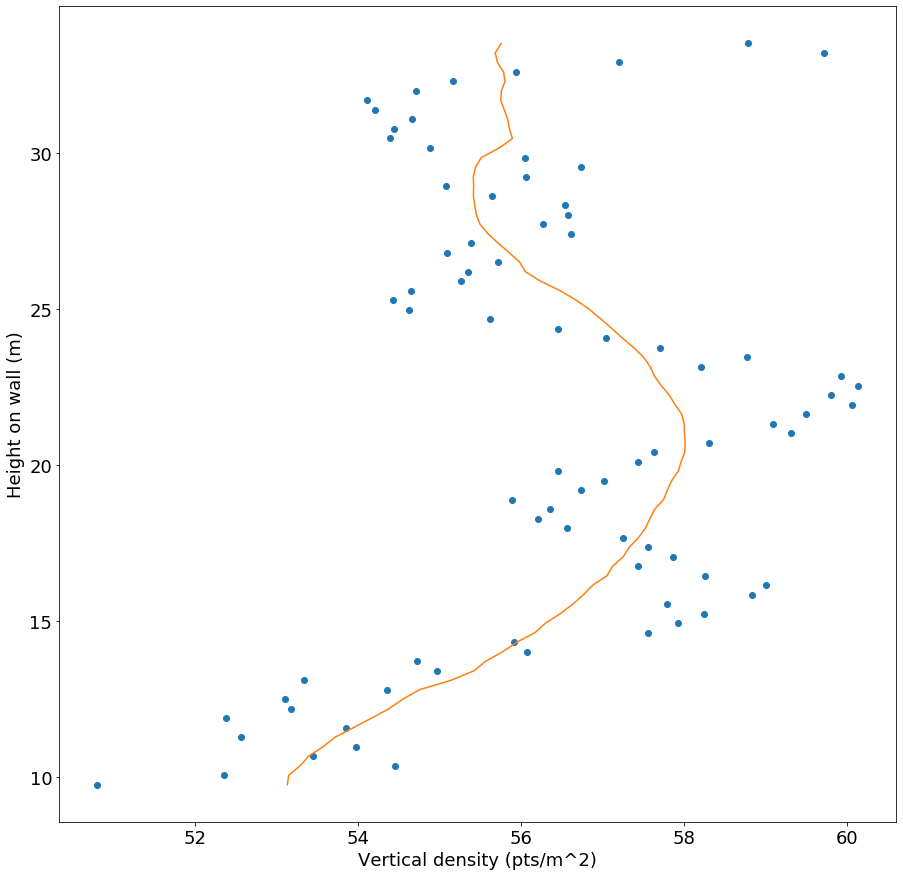

In [25]:
quantized.head()
plt.figure(figsize=[15,15])
plt.plot(quantized['laefer']/0.092903,quantized.index/3.28084,'o')
plt.plot(quantized['trend']/0.092903,quantized.index/3.28084)
plt.ylabel("Height on wall (m)",fontsize=18)
plt.xlabel("Vertical density (pts/m^2)",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

In [ ]:
print("\n\n2017 scan (Horizontal, 10,000 samples): \n"+"*"*30)
print("Avg points per square: {:2.2f}".format((4 * feet_from_point**2)*np.mean(pt_density_nyc_list)))
print("Avg density: {:2.4f} pts/sqft (SD: {:2.4f})".format(np.mean(pt_density_nyc_list),np.std(pt_density_nyc_list)))
print("Avg number of flight paths per square: {:2.2f}".format(avg_flight_paths_nyc))
print("]nphi_total: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_nyc_total),np.std(phis_nyc_total)))
print("phi_sample: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_nyc_sample),np.std(phis_nyc_sample)))
print("Total point dist from plane, SD: {:2.4f} feet".format(sd_nyc_total))
print("Avg flight point dist from plane, SD: {:2.4f} feet".format(sd_nyc_total/np.mean(phis_nyc_total)))

In [ ]:
# Plotting
plotting_laefer,_ = prep_square_for_plotting(wall_face_nyc)
fig = px.scatter_3d(plotting_laefer, x='x_scaled', y='y_scaled', z='z_scaled',
              size = 'size_num',size_max = 12)

fig.update_layout( 
    scene = dict(xaxis = dict(title="Easting (feet)"),
                 yaxis = dict(title="Northing (feet)"),
                 zaxis = dict(title="Vertical (feet)"),
                ),
    width=900,
    height=900,
    margin=dict(r=20, l=10, b=10, t=10),
    showlegend=False,
    )
fig.show()

#### NYC data

In [ ]:
'''
Random sample of horizonal density from front parking lot
Laefer: 
******************************
SD total: 0.0389
SD sample: 0.0382
mean of phi_total: 1.2279
SD of phi_total:   0.1140
mean of phi_sample: 1.2030
SD of phi_sample:   0.2304

NYC: 
******************************
SD total: 0.0602
SD sample: 0.0544
mean of phi_total: 1.3172
SD of phi_total:   0.2091
mean of phi_sample: 1.2021
SD of phi_sample:   0.3375
'''

In [ ]:
# Access the NYC header file
#inFileNYC = File(nyc_file_dir+'975172.las', mode='r')

# Extract points within a square around the desired point
# Use pt_[]_bldg and feet_from_pt from previous cell

# Use same min's from previous so points line up.
#square_points_nyc,_ = prep_square_for_plotting(square_points_nyc,min_list) 

#### 3D Plots

In [ ]:
fig = px.scatter_3d(square_points_bldg, x='x_plot', y='y_plot', z='z_plot',
              size='size_num',size_max = 12)

fig.update_layout( 
    scene = dict(xaxis = dict(title="Easting (feet)"),
                 yaxis = dict(title="Northing (feet)"),
                 zaxis = dict(title="Vertical (feet)"),
                ),
    width=900,
    height=900,
    margin=dict(r=20, l=10, b=10, t=10),
    showlegend=False,
    )
fig.show()

In [ ]:
fig = px.scatter_3d(square_points_nyc, x='x_plot', y='y_plot', z='z_plot',
              size='size_num',size_max = 12)

fig.update_layout( 
    scene = dict(xaxis = dict(title="Easting (feet)"),
                 yaxis = dict(title="Northing (feet)"),
                 zaxis = dict(title="Vertical (feet)"),
                ),
    width=900,
    height=900,
    margin=dict(r=20, l=10, b=10, t=10),
    showlegend=False,
    )
fig.show()

#### Extract the wall face, find normal vector, calculate vertical density

In [ ]:
pt_1 = np.array([37.7,10.04])
pt_2 = np.array([27.094,18.439])
wall_pt = (31.77,14.90,43.00)

# East? Facing Wall (farther from the little stump)
# pt_1 = np.array([20.59,15.02])
# pt_2 = np.array([10.34,2.93])
# wall_pt = (19.414,12.379,73.863)

wall_face = grab_wall_face(square_points_bldg,pt_1,pt_2,20,100,1e-2)
wall_face_nyc = grab_wall_face(square_points_nyc,pt_1,pt_2,20,100,5e-2)

In [ ]:
wall_face.shape

In [ ]:
wall_face_nyc.shape

In [ ]:
norm_vector,points,wall_face,pts_on_plane = plane_fit(wall_face)

In [ ]:
print(norm_vector)
print(norm_vector_nyc)

In [ ]:
norm_vector_nyc,points,wall_face_nyc,pts_on_plane_nyc = plane_fit(wall_face)

In [ ]:
fig = px.scatter_3d(wall_face, x='x_plot', y='y_plot', z='z_plot',
              color='flight_id',size='size_num',size_max = 12)

fig.update_layout( 
    scene = dict(xaxis = dict(title="Easting (feet)"),
                 yaxis = dict(title="Northing (feet)"),
                 zaxis = dict(title="Vertical (feet)"),
                ),
    width=900,
    height=900,
    margin=dict(r=20, l=10, b=10, t=10),
    showlegend=False,
    )
fig.show()

In [ ]:
# Point in middle of wall - in xyz_plot coordinates (less the min of each coordinate)
# It's best to highlight a point in the plot above and use that.

feet_from_pt = 3

In [ ]:
# Calculate density for both datasets   
vertical_point_density(square_points_nyc,norm_vector_nyc,wall_pt,feet_from_pt)
vertical_point_density(square_points_bldg,norm_vector,wall_pt,feet_from_pt)

In [ ]:
fig = px.scatter_3d(vertical_square, x='x_plot', y='y_plot', z='z_plot',
              color='flight_id', size='size_num',size_max = 8)

fig.update_layout( 
    scene = dict(xaxis = dict(title="Easting (feet)"),
                 yaxis = dict(title="Northing (feet)"),
                 zaxis = dict(title="Vertical (feet)"),
                ),
    width=900,
    height=900,
    margin=dict(r=20, l=10, b=10, t=10),
    showlegend=False,
    xaxis = {"title":{"text":"Cat"}})
fig.show()

### Writing LAS file

In [ ]:
# Write square_points_bldg to file
inFile = File(file_dir+'10552_NYU_M2 - Scanner 1 - 190511_164039_1 - originalpoints.laz', mode='r')
# Convert DF into tuples that laspy wants
void = [(tuple(r[columns_point_cloud]),) for i,r in square_points_laefer.iterrows()]
# Export
outFile1 = File("../../Data/parking_lot/flat_parking_lot_laefer.las", mode = "w",header = inFile.header)
outFile1.points = void
outFile1.close()

In [ ]:
# NYC data
# Write square_points_bldg to file
inFile_nyc = File(nyc_file_dir+'975172.las', mode='r')
# Convert DF into tuples that laspy wants
void = [(tuple(r[columns_point_cloud]),) for i,r in square_points_nyc.iterrows()]
# Export
outFile1 = File("../../Data/parking_lot/flat_parking_lot_nyc.las", mode = "w",header = inFile.header)
outFile1.points = void
outFile1.close()

## Plotting charts from previous updates

In [ ]:
norm_vector,points,square_points,_ = plane_fit(square_points)

# Add distance from flat plane with norm (x,y,z) = (0,0,1)
square_points['dist_from_flat']=np.array([np.dot(point,np.array([0,0,1])) for point in points])

# remove data points >5 feet below plane.
outliers = square_points[square_points['dist_from_plane']<-5].index
square_points = square_points.drop(outliers)

In [ ]:
def plot_scan_angle_dist_from_plane(df,distance_metric):
    x = abs(df['scan_angle'])*.006
    y = df[distance_metric]
    plt.figure(figsize=(15,15))
    plt.plot(x,y,'xb')
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.xlabel("Scan angle (degrees)")
    plt.ylabel("Point distance from plane")
    print("y={:2.8f}x+{:2.8f}".format(z[0],z[1]))
    plt.title("Scan Angle vs Distance to Fitted Plane")
plot_scan_angle_dist_from_plane(square_points,'dist_from_plane')

In [ ]:
plt.plot(range(len(square_points)),square_points['scan_angle'],'x')

In [ ]:
plot_scan_angle_dist_from_plane(square_points,'dist_from_flat')

In [ ]:
# Chart from slides showing points per run
labels = [pt[0][11:-4] for pt in pts_from_scan]
num_points = [pt[1]+.01 for pt in pts_from_scan]
plt.figure(figsize=(25,20))
plt.bar(labels,num_points,)
plt.xticks(rotation=45,fontsize=20)
plt.yticks(np.arange(0, max(num_points), step=(max(num_points)/10)),fontsize=20)
plt.ylabel("Number of points from run",fontsize=20)
plt.xlabel("Run ID",fontsize=20)

### USGS: Converting Lat-Lon and adding flight id's

In [ ]:
# Converting lat-lon to state plane
from pyproj import Proj, transform
y1 = np.array(usgs_square_points['x_scaled'])
x1 = np.array(usgs_square_points['y_scaled'])
inProj = Proj('epsg:4269')
outProj = Proj('epsg:3628')
x2,y2 = transform(inProj,outProj,x1,y1)
usgs_square_points['latitude'] = usgs_square_points['y_scaled'].copy()
usgs_square_points['longitude'] = usgs_square_points['x_scaled'].copy()
usgs_square_points['x_scaled'] = x2
usgs_square_points['y_scaled'] = y2